# Final Report

 - **Course**          : Introduction to Machine Learning and Data Mining
 - **Univerisity**     : DTU, Lyngby (Denmark)
 - **Dates**            : 5-9 March 2018
 - **Report deadline** : 19 March 2018
 - **Dataset**         : South Africa Heart Disease (available [here](https://web.stanford.edu/~hastie/ElemStatLearn/datasets/SAheart.data))


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import tree, model_selection
import sklearn.linear_model as lm
from scipy.linalg import svd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import sys

sys.path.append('/home/ben/courses/report/ml_tools')
import lreg_tools as lreg

In [2]:
sns.set_context("notebook", font_scale=1.5)
pd.options.mode.chained_assignment = None

In [3]:
# Loading the data
data = pd.read_csv('data.csv')
data.head()

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


In [4]:
# data types
data.dtypes

row.names      int64
sbp            int64
tobacco      float64
ldl          float64
adiposity    float64
famhist       object
typea          int64
obesity      float64
alcohol      float64
age            int64
chd            int64
dtype: object

In [5]:
# Number of rows with missing values
len(data) - len(data.dropna())

0

In [6]:
data.describe()

,row.names,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,231.935065,138.326840,3.635649,4.740325,25.406732,53.103896,26.044113,17.044394,42.816017,0.346320
std,133.938585,20.496317,4.593024,2.070909,7.780699,9.817534,4.213680,24.481059,14.608956,0.476313
min,1.000000,101.000000,0.000000,0.980000,6.740000,13.000000,14.700000,0.000000,15.000000,0.000000
25%,116.250000,124.000000,0.052500,3.282500,19.775000,47.000000,22.985000,0.510000,31.000000,0.000000
50%,231.500000,134.000000,2.000000,4.340000,26.115000,53.000000,25.805000,7.510000,45.000000,0.000000
75%,347.750000,148.000000,5.500000,5.790000,31.227500,60.000000,28.497500,23.892500,55.000000,1.000000
max,463.000000,218.000000,31.200000,15.330000,42.490000,78.000000,46.580000,147.190000,64.000000,1.000000


### After a quick inspection of the dataset, the following can be stated:


- **Main Problem of interest** : 

The main interest of this dataset is to predict if a certain patient has developed a coronary heart disease (binary prediction or likelihood via probability) based on a set of 9 attributes. So in essence, this is a classification problem.


- **Other use of the dataset when studying regression, clustering, association mining and anomaly detection**:
   - Regression: e.g predicting obesity as a function of sbp, tabacco, ldl, age, typea, adiposity and alcohol
   - Clustering: it could be interesting to look at the amount of clusters that can be formed by:
        - looking at the following attributes (or a subsample of these attributes): adiposity, age, alcohool and tabacco 
        - checking later if they correlate with a 2 or 3 obesity class (specified by range intervals of the obesity continous variable)
   - Association mining
   - Anomaly detection
   
   
- **Data Transformations**: 
  - famhist (family history of coronary heart disease) is a categorical nominal variable(Present /  Absent) so it should be converted to Binary in one single binary column [0,1].
  - Applying the describe() method shows that all data attributes (all columns expect of 'chd' and 'row.names') need to be standardized since the order of magnitude of some attrbutes are much larger than others (O(sbp) > O(tabacco))
  
  
- ** Attribute description**:
   - shp: discrete / ratio
   - tabacco: continuous / ratio
   - ldl: continuous / ratio
   - adiposity: continuous / ratio
   - famhist: binary / nominal
   - typea: discrete / interval
   - obesity: continuous / ratio
   - alcohol: continuous / ratio
   - age: discrete / ratio
   - chd: binary / nominal
   
   
- **Data issues**: No data issues have been identified (no missing values + no suspicious attribute min/max values)

In [7]:
def binarize(x):
    if x == 'Present':
        return 1
    else:
        return 0

data['famhist'] = data['famhist'].apply(lambda x: binarize(x))

In [8]:
# Define attribute names
attribute_names = [col for col in data.columns if col not in ['chd', 'row.names']]
array_data = np.asarray(data[attribute_names])

# Scale data using sklearn StandardScaler class (scale by sustracting attribute mean and normalizing by std)
scaler = StandardScaler()
scaler.fit(array_data)
array_data_tr = scaler.transform(array_data)
data_tr = pd.DataFrame(array_data_tr, columns=attribute_names)
data_tr['chd'] = data.loc[:,'chd']

# Sort by predictant values (y = 0,1)
data_tr.sort_values('chd', inplace=True)
data_tr.reset_index(inplace=True, drop=True)
data_tr.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1.156248,0.362758,1.551567,1.051593,1.185854,0.499251,2.379569,-0.360440,0.355234,0
1,0.228247,0.306089,0.057851,-0.233745,-0.843274,0.499251,-0.321709,0.068519,-0.055918,0
2,-0.309016,0.794314,-0.589909,-1.682485,-0.843274,0.703189,-1.559499,-0.612745,0.903437,0
3,0.277089,-0.269319,1.638580,1.312778,-0.843274,-0.724377,0.317379,-0.150254,1.177539,0
4,-0.504385,-0.225728,0.096524,-0.520663,-0.843274,0.805158,-1.127104,-0.696983,-0.809697,0


# PCA analysis

### Variance Explained
From the Variance explained plots shown below, it can be observed that in this dataset there is not much gained by performing a PCA since you tend to loose quite a lot of information if you just keep a few Principal components (i.e it can be seen in the cumulative sum plot that you need 7 out of 9 principal components to explain around 92% of the variance of the original dataset). On the other hand, the first principal component only explains roughly 33% of the variability of the original dataset. One could also state that these results reflect the fact that the original features are not very correlated between each other and a safe approach would be to keep them all for a later modelling analysis.

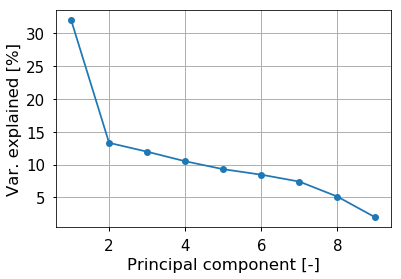

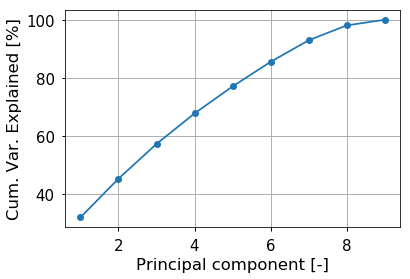

In [9]:
# Define matrix X containing 9 attributes correctly scaled
df_X = data_tr[attribute_names]
X = np.asarray(df_X)

# Perform singular value decomposition
U, S, V = svd(X, full_matrices=False)

# Variance explained
var_explained = S*S / np.sum(S*S)

# Plots of variable explained
plt.figure()
plt.plot(np.arange(1, len(var_explained) + 1), var_explained * 100., '-o')
plt.xlabel('Principal component [-]')
plt.ylabel('Var. explained [%]')
plt.grid()

plt.figure()
plt.plot(np.arange(1, len(var_explained) + 1), np.cumsum(var_explained * 100.), '-o')
plt.xlabel('Principal component [-]')
plt.ylabel('Cum. Var. Explained [%]')
plt.grid()

### Principal component directions

From the plots below, it can be seen that the predominant direction corresponds to:
 - a) The typeA feature for the first principal component
 - b) The famhist feature for the second principal component

It can be concluded that the typeA feature is the feature that explains most of the variance in the dataset. 

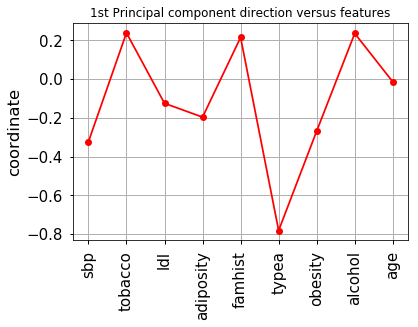

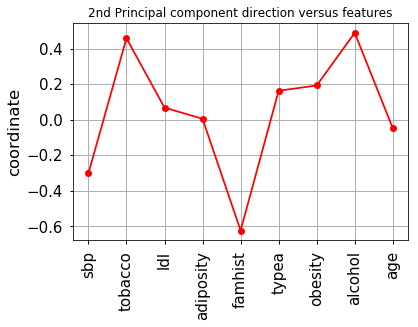

In [10]:
# The eigenvalue vectors or principal components are simply the columns of V, so we transpose V and get the rows.
Vt = V.T

plt.figure()
plt.title('1st Principal component direction versus features', size=12)
plt.plot(np.arange(1,len(Vt[0]) + 1), Vt[0], 'ro-')
plt.xticks(np.arange(1,len(Vt[0]) + 1), list(df_X.columns), rotation='vertical')
plt.ylabel('coordinate')
plt.grid()

plt.figure()
plt.title('2nd Principal component direction versus features', size=12)
plt.plot(np.arange(1,len(Vt[1]) + 1), Vt[1], 'ro-')
plt.xticks(np.arange(1,len(Vt[1]) + 1), list(df_X.columns), rotation='vertical')
plt.ylabel('coordinate')
plt.grid()

### Dataset projected into the first 2 principal components

The projected data can be computed by simply matrix multiplying the transpose of X with the first two eigenvectors of V respectively. We create two sets of X to account for the 2 existing classes.

It can be seen from the plot that:
 - a) as expected, PC1 shows most of the variability of the data (larger scatter in the x direction)
 - b) Both classes overlap quite a lot (it is difficult to find a 'class splitting' rule)

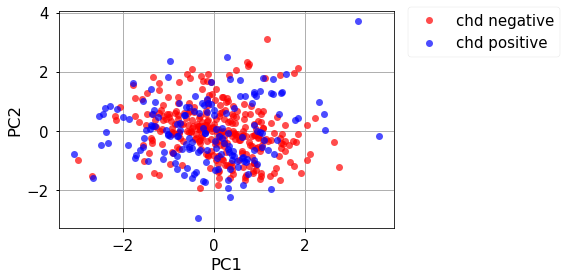

In [11]:
# For plotting purposes, we first create 2 np.ndarrays (X_neg and X_pos) each of them containing a 'chd' class
X_neg = np.asarray(data_tr[attribute_names][data_tr['chd'] == 0])
X_pos = np.asarray(data_tr[attribute_names][data_tr['chd'] == 1])

# 1st component projection
PC1_neg = np.asarray(np.matrix(X_neg) @ np.matrix(Vt[0]).T).flatten()
PC1_pos = np.asarray(np.matrix(X_pos) @ np.matrix(Vt[0]).T).flatten()

# 2nd component projection
PC2_neg = np.asarray(np.matrix(X_neg) @ np.matrix(Vt[1]).T).flatten()
PC2_pos = np.asarray(np.matrix(X_pos) @ np.matrix(Vt[1]).T).flatten()

plt.figure()
plt.plot(PC1_neg, PC2_neg, 'ro', label='chd negative', alpha=0.7)
plt.plot(PC1_pos, PC2_pos, 'bo', label='chd positive', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(bbox_to_anchor=(1.02, 1.05))
plt.grid()

### Summary statistics of attributes

Mean, Std, Median, Max, Min and 25,75 quantiles have been already calculated in the first section using the describe() method. Computing these quantities was useful since we observed differences in scale between certain attributes and also negleted for potential outliers by looking at the max and min values.


### Covariance analysis
We still have not looked into the potential (linear) correlation between the different attributes. We do this by computing the covariance matrix of the scaled matrix X (which is actually equal to the correlation matrix)

From the plot below, it can be seen than:
 - a) the diagonal elements are the actual variances of each attribute which are equal to 1 since we have scaled X by deviding it by the standard deviation.
 - b) the coviariance matrix is symetric so we should inspect the upper of lower part of the matrix
 - c) correlation between attributes is generally low except for:
       - adiposity versus obesity (0.72) --> moderate linear correlation
       - age versus adiposity (0.63) --> some correlation
       - The remaining pairs have correlation below 0.5





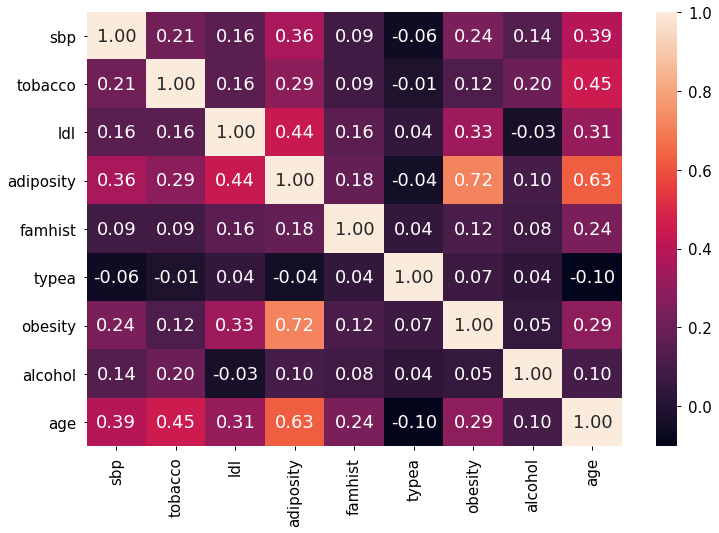

In [12]:
# We Transpose X since the np.cov() function takes each column of X as a single observation
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(np.cov(X.T), xticklabels=df_X.columns, yticklabels=df_X.columns, annot=True, fmt='.2f')

## Data visualization

#### a) Boxplot for each attribute (scaled)
We can confirm by inspecting this plot that there are no apparent outliers in the data. On the other hand, one can also state that the attributes 'alcohol' and 'tabacco' are highly positively skewed. 

#### b) Histogram of each attribute + attribute pair scatter plots (scaled)
This plot tells us alot. The diagonal shows the staked histogram distributions of each attribute considering the 2 existing classes (chd=1 and chd=0). The non-diagonal plots are scatter plots of pairwise attributes. A simple inspection reveals several aspects about this dataset:
 - age histogram follows a close to uniform distribution (ages are almost represented equally)
 - tabacco and alcohol follow a 'negative exponential distribution'
 - all other histrograms are closer to a gausian distribution (some are skewed however, especially sdp and ldl)
 - the scatter plots show a low correlation between variables in general except for the already mentioned pairs ({obesity, adiposity}, {age, adiposity})
 - the scatter plots reveal that overall both classes are difficult to discern (no clear separation)



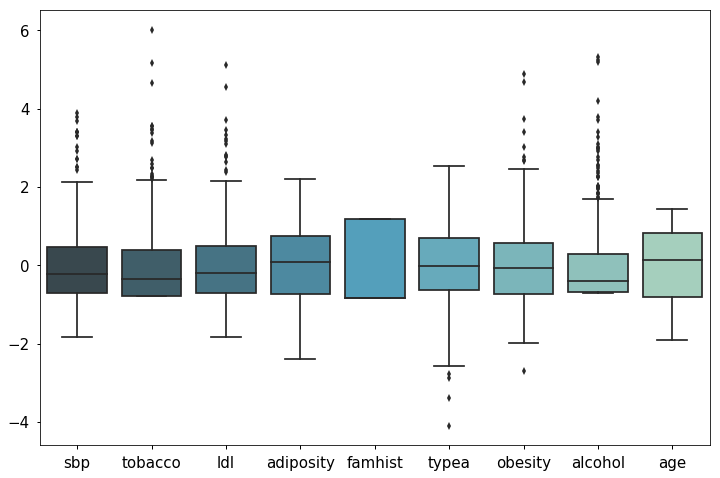

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(ax=ax, data=data_tr[attribute_names],palette='GnBu_d')

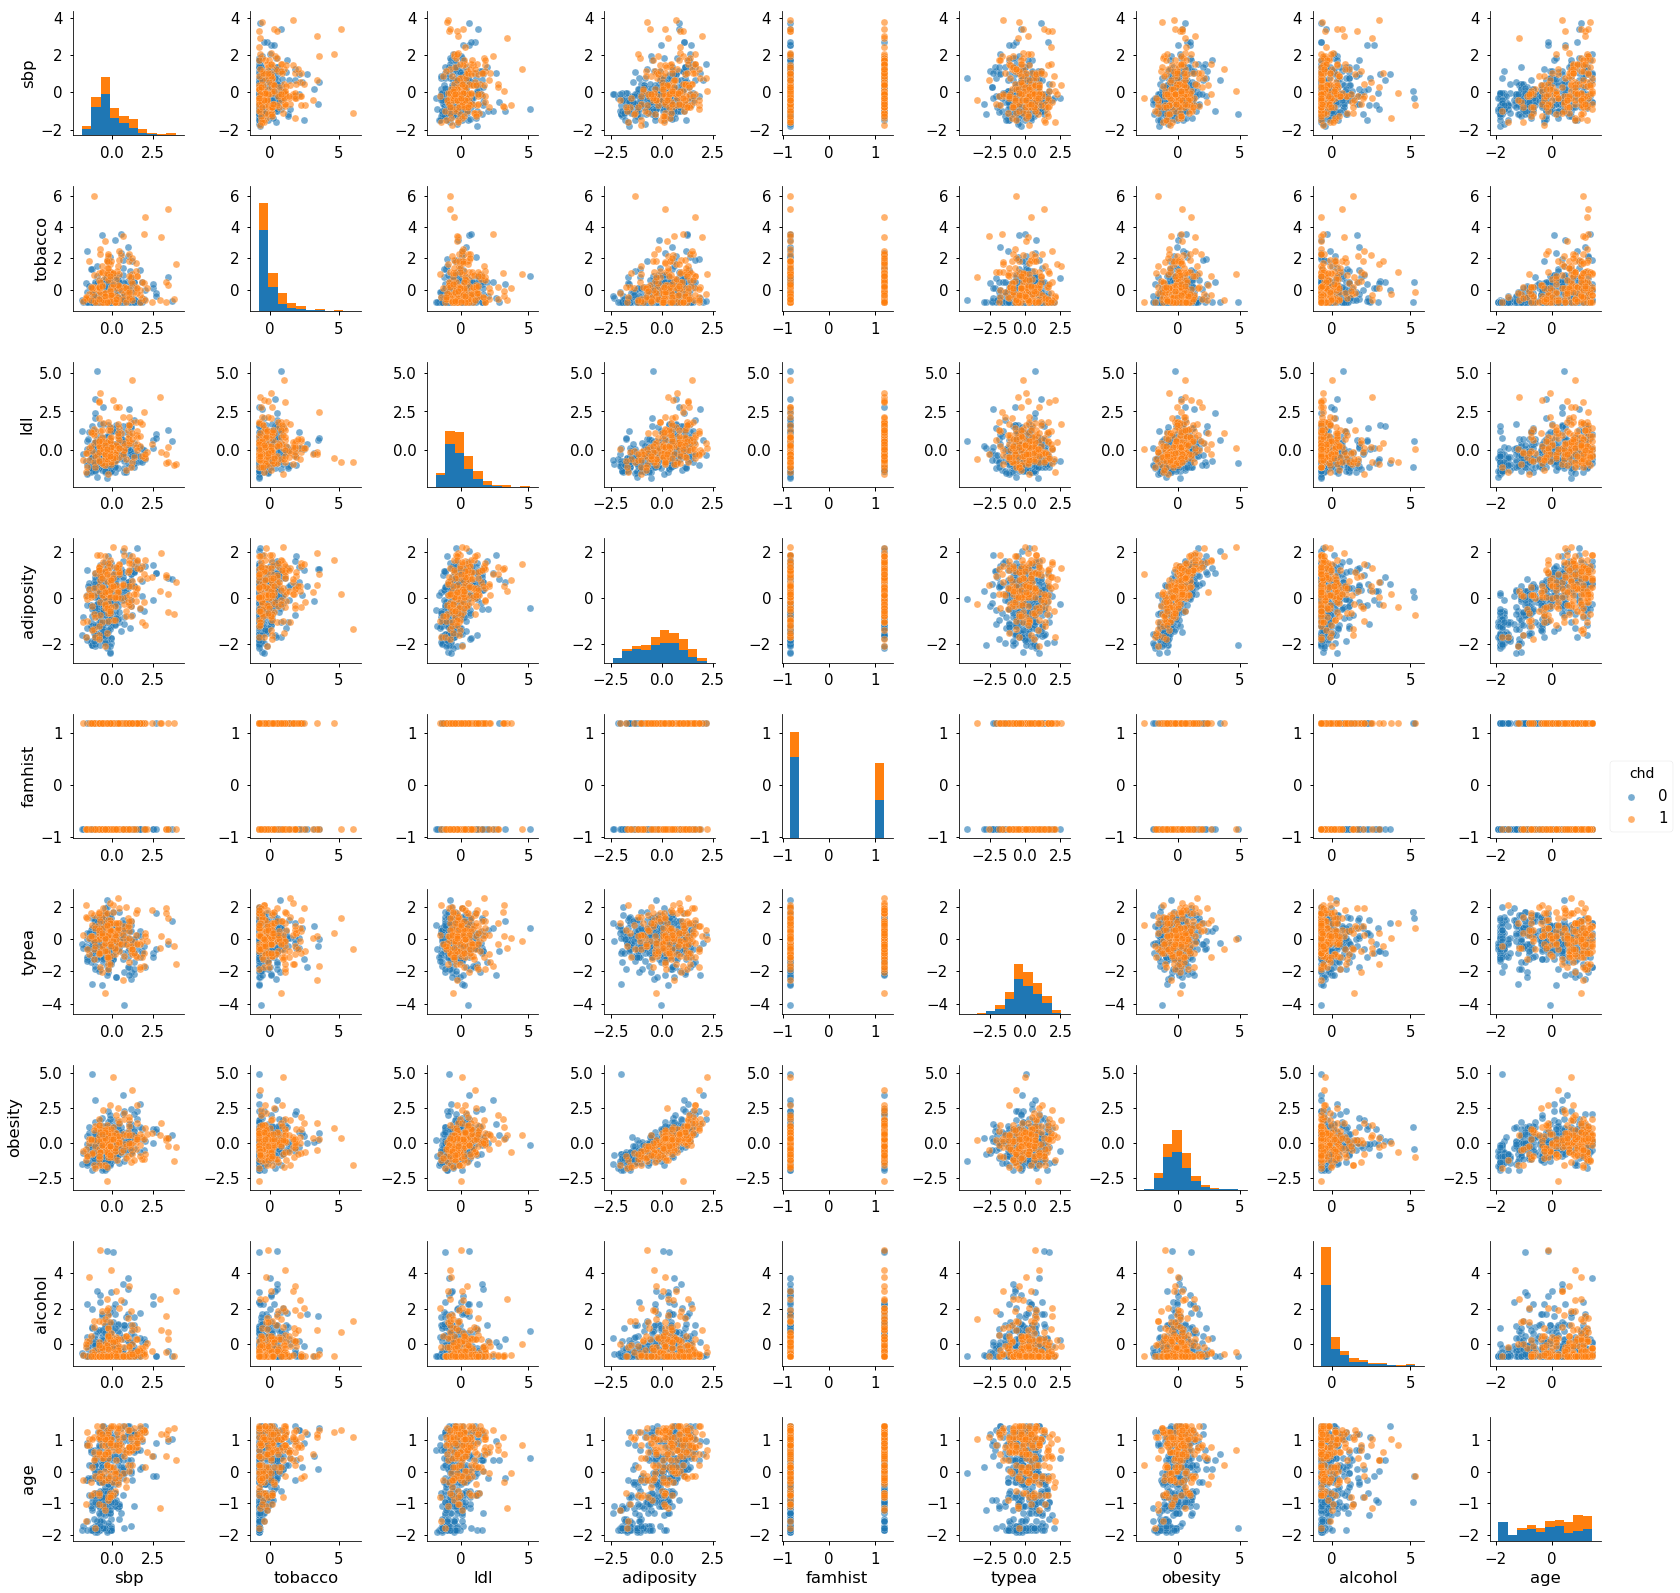

In [14]:
sns.pairplot(data=data_tr, hue='chd',x_vars=attribute_names, y_vars=attribute_names, plot_kws={'alpha': 0.6})

# Supervised learning (classification)

In this section we will investigate the accuracy of different classification supervised machine learning methods in predicting Coronary Heart Disease (chd) based on the 9 available attributes. So in essence:

 - X = {sbp, tabacco, ldl, adiposity, famhist, typea, obesity, alcohol, age}
 - y = chd
 
### Decision trees
We use Hunt's decision tree algorithm using the gini splitting criterion.
We start by leaving one observation aside before fitting maximum tree depth using leave-one-out cross-validation on the rest of the data. This observation is used for testing and interpreting the final model (fitted on [all the data - 1] using the tree depth that gave the best cross-validation result).

**Results:**
 - It can be seen that a tree depth of 3 gives the best accuracy which is 76% (misclassification rate of 0.24%).
 - The testing observation is a true negative. One can interpret this result by following the tree provided in the tree scketch shown below {True --> False --> True}. One ends up in a leave where 73% of the observations in the training set were classified as 'chd absent'.


In [15]:
# Defining the target variable
y = np.asarray(data_tr['chd'])

# We leave the first observation out for testing & interpreting the final model (fitted on
# the entire dataset minus the first observation and using the maximum tree depth found 
# in the leave-one-out cross-validation step which in turn does not consider 
# this observation). 
y_final = y[0]
X_final = X[0,:]

X_dtc = X[1:,:]
y_dtc = y[1:]

In [16]:
## User inputs

# Maximum Tree depths
tc = np.arange(2, 21, 1)

# Purity gain criterion
criterion = 'gini'

Best fit corresponds to a max. tree depth of 3
Best misclassification rate: 0.24


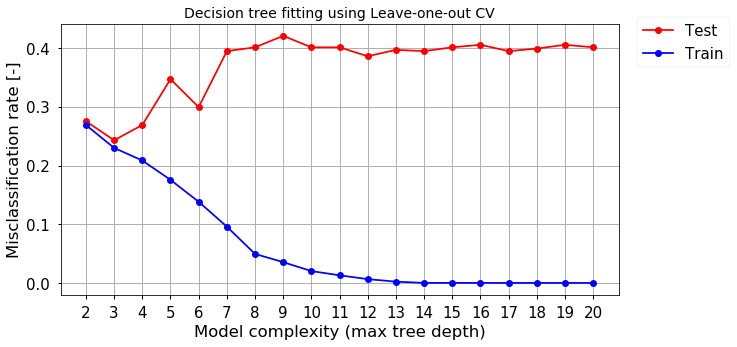

In [17]:
CV = model_selection.LeaveOneOut()

Error_train, Error_test = [], []
for train_index, test_index in CV.split(X_dtc):
    X_train, y_train = X_dtc[train_index,:], y_dtc[train_index]
    X_test, y_test = X_dtc[test_index,:], y_dtc[test_index]
    misclass_test, misclass_train = [], []
    for i, t in enumerate(tc):
        # Fit decision tree classifier, Gini split criterion, different pruning levels
        dtc = tree.DecisionTreeClassifier(criterion=criterion, max_depth=t)
        dtc = dtc.fit(X_train,y_train.ravel())
        y_est_test = dtc.predict(X_test)
        y_est_train = dtc.predict(X_train)
        # Evaluate misclassification rate over train/test data
        misclass_test.append(np.abs(y_est_test - y_test))
        misclass_train.append(np.sum(np.abs(y_est_train - y_train)) / len(y_est_train))
        
    Error_train.append(misclass_train)
    Error_test.append(misclass_test)

colnames_dt = [str(i) for i in tc]
Error_test_df = pd.DataFrame(Error_test, columns=colnames_dt)
Error_train_df = pd.DataFrame(Error_train, columns=colnames_dt)

plt.figure(figsize=(10,5))
plt.title('Decision tree fitting using Leave-one-out CV', size=14)
plt.plot(tc, Error_test_df.mean(), 'ro-',label='Test')
plt.plot(tc, Error_train_df.mean(), 'bo-',label='Train')
plt.xlabel('Model complexity (max tree depth)')
plt.ylabel('Misclassification rate [-]')
plt.xticks(tc)
plt.grid()
plt.legend(bbox_to_anchor=(1.02, 1.05))

print('Best fit corresponds to a max. tree depth of {}'.format(Error_test_df.mean().idxmin()))
print('Best misclassification rate: {}'.format(np.round(np.min(Error_test_df.mean()),2)))

In [18]:
# Fitting final model & making prediction on the observation which was left aside
dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth=3)
dtc = dtc.fit(X_dtc,y_dtc.ravel())
print('observation:')
print(pd.DataFrame(X_final.reshape(1,-1), columns=attribute_names))
print('\nprediction: {}'.format(int(dtc.predict(X_final.reshape(1,-1)))))
print('\nobservation: {}'.format(y_final))

observation:
        sbp   tobacco       ldl  adiposity   famhist     typea   obesity  \
0  1.156248  0.362758  1.551567   1.051593  1.185854  0.499251  2.379569   

   alcohol       age  
0 -0.36044  0.355234  

prediction: 0

observation: 0


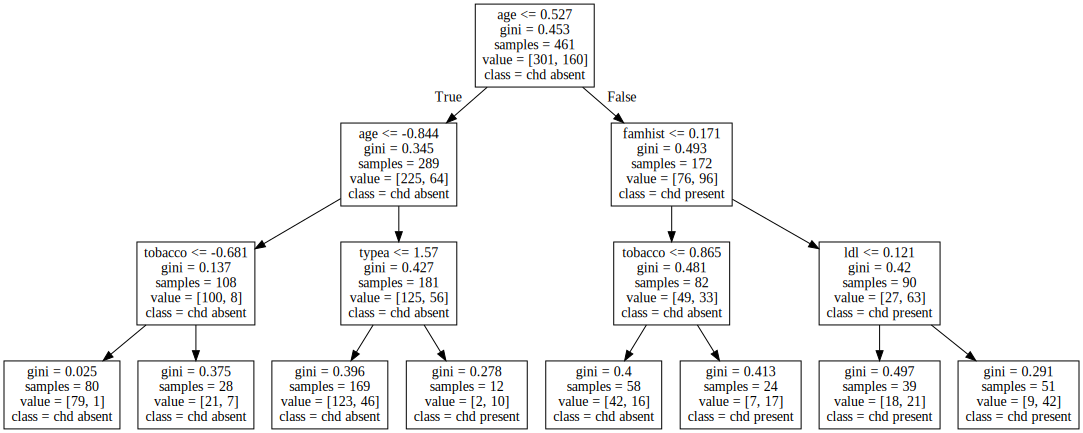

In [19]:
# Tree visualization
out = tree.export_graphviz(dtc, out_file='tree_gini.dot', 
                           feature_names=attribute_names,
                           class_names=['chd absent','chd present'])
with open("tree_gini.dot") as f:
   dot_graph = f.read()
graphviz.Source(dot_graph)

# Supervised learning (regression)

In this section we will investigate the performance of different supervised learning regression models in predicting obesity. We will use the attributes shown below (we exclude the boolean variable famhist) and will also investigate potential transformations of the attributes (polynomial form or interaction form terms). So in essence:

 - X = {sbp, tobacco, ldl, adiposity, typea, alcohol, age}
 - y = obesity
 
### Linear regression
We use a 2 layer Cross Validation setup using forward feature selection in the inner CV fold for model selection.
We evaluate the mean square test error (MSE) accross all outer cross-validation folds (best approximation of the generalization error) in two scenarios:
   - using feature selection
   - without using feature selection
   
For this we test different sets of attributes in the following order:
   - 1) all attributes without including any transformations
   - 2) all attributes including polynomial transformations of the most relevant attributes found in 1)
   - 3) Most relevant set of attributes found in 2) including interaction terms.
   
We leave a small number of observations (max 20) out of the dataset which is in the last stage used to interpret and test the final model.
  
__Results:__
   - When performing step 1), we observe that the most relevant attributes are (in order): __{adiposity, age, typea}__
   - The MSE in 1) including feature selection (which in 4 out of 5 folds takes adiposity, age and typea attributes only)  is around 0.45. The MSE is only slightly higher when including all attributes (0rd(-3) higher) which suggest that the non-selected attributes have very small weights in the linear model.
   - In 1) we observe that the apidosity residuals (most relevant feature) have a slight curvature which suggests that adding adiposity polynomial transformations into the algorithm might improve results. The same can be said about the age attribute.
   - It was found that including the square of adiposity and the cube of age increased model performance (MSE accross all CV folds goes down to 0.42). It is nonetheless not a big improvement.
   - Including the interaction term between age and adiposity was tested but this did not lead to an improvement of the MSE. 
   - The best model thus is constructed using the following attributes (sorted by order of relevance):
     __{adiposity, age, adiposity^2, age^3, typea}__

In [20]:
# redefining target and attribute variables 
y_lr = df_X['obesity']
cols_lr = [col for col in df_X.columns if col not in ['famhist', 'obesity']]
X_lr = df_X[cols_lr]

In [21]:
# adding transformations which are also scaled by mean and standard deviation
power_dict = {'adiposity' : [2], 'age' : [3]}
X_lr = lreg.transform_attributes(X_lr, power_dict=power_dict, standard_scaler=True)

In [22]:
# Number of observations to test the model
m = 10

# Splitting test and model dataframes
X_lr_model = X_lr.loc[m:, X_lr.columns]
y_lr_model = y_lr[m:]

X_lr_test = X_lr.loc[0:(m-1), X_lr.columns] 
y_lr_test = y_lr[0:m]

X_lr_model.head()

,sbp,tobacco,ldl,adiposity,typea,alcohol,age,p(adiposity)2,p(age)3
10,-0.211332,-0.792417,-1.131320,-0.552828,0.397282,-0.640960,-1.700527,-0.609259,-2.059444
11,-0.309016,-0.792417,-1.817753,-0.516803,0.907127,-0.696983,0.697861,-0.643069,0.326982
12,-1.090491,-0.138545,-0.817108,0.630867,-1.234222,-0.661815,0.081133,-0.528209,0.172954
13,0.277089,-0.792417,-0.275697,0.543376,-0.112563,-0.696983,1.109013,-0.618350,0.791846
14,-0.211332,-0.781519,1.590239,0.327223,-0.520439,-0.696983,1.177539,-0.783463,0.913851


In [23]:
df_features, df_error, feature_record_list, loss_record_list = lreg.lreg_2lcv_fs(X_lr_model, y_lr_model)

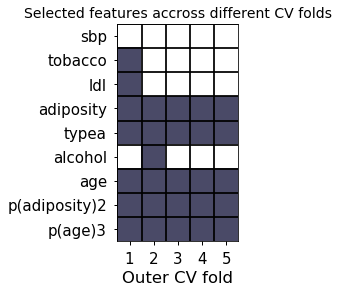

In [24]:
lreg.bmplot(df_features.index, np.arange(1, len(df_features.columns) + 1), -np.asarray(df_features))
plt.xlabel('Outer CV fold')
plt.title('Selected features accross different CV folds', size=14)
plt.clim(-1.5,0)

In [25]:
df_error

,error_train,error_test,error_train_fs,error_test_fs,error_train_nf,error_test_nf
CVFold1,0.369979,0.549871,0.370440,0.550711,0.908324,1.278339
CVFold2,0.343601,0.660474,0.345847,0.658706,0.987089,0.985347
CVFold3,0.411499,0.382095,0.413790,0.378065,0.980249,0.993944
CVFold4,0.446581,0.243418,0.447622,0.242390,1.049704,0.720101
CVFold5,0.436544,0.279771,0.438506,0.275274,1.004892,0.900861
mean_error,0.401641,0.423126,0.403241,0.421029,0.986051,0.975718
r2,0.592678,0.560410,0.591055,0.562536,0.000000,0.000000


<function matplotlib.pyplot.figure>

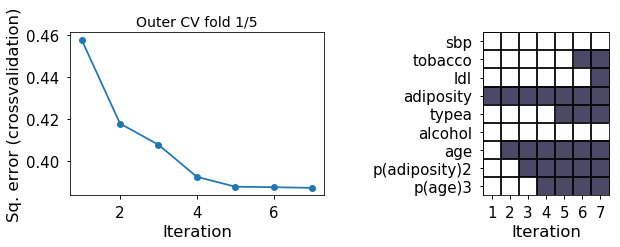

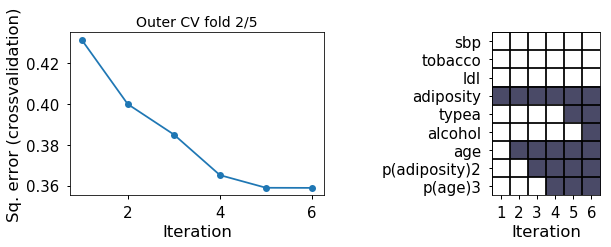

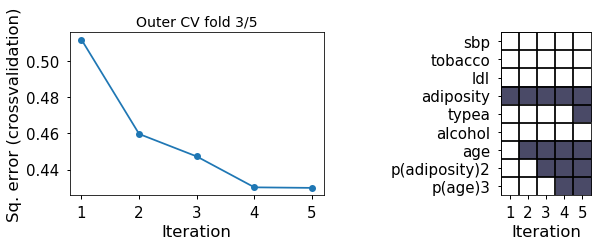

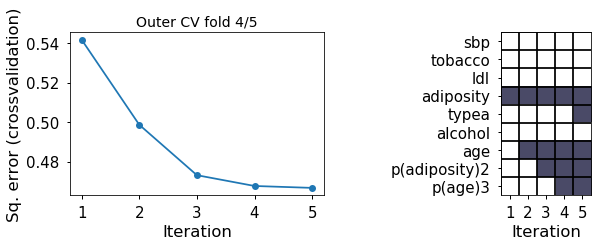

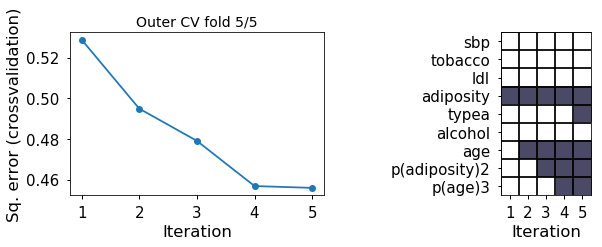

In [26]:
lreg.plot_lr_record(df_features, feature_record_list, loss_record_list)
plt.figure

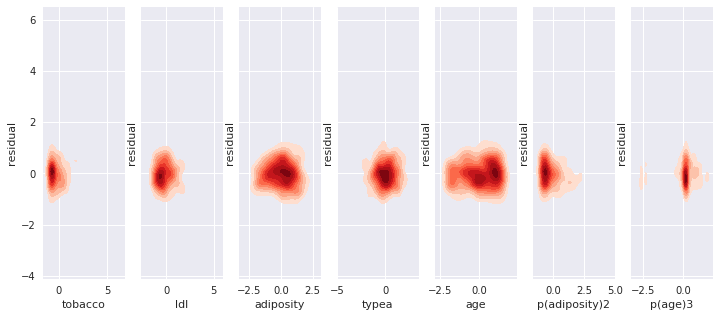

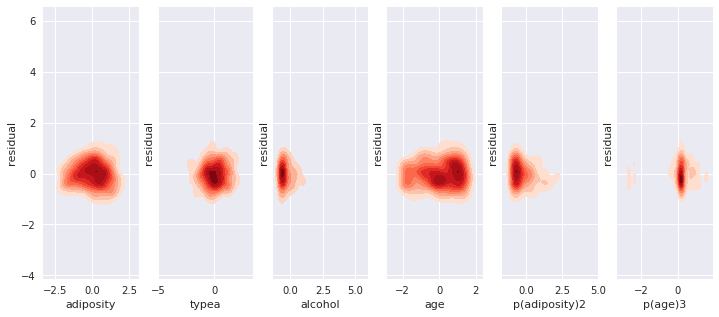

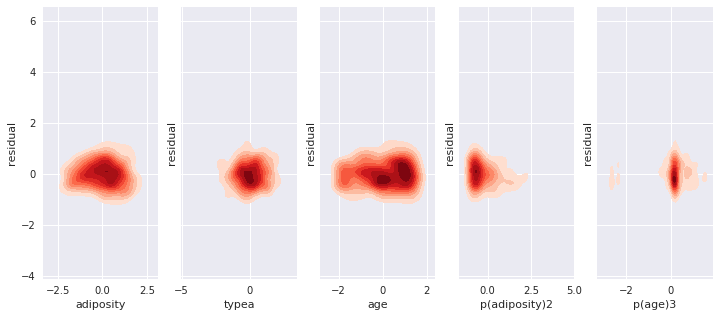

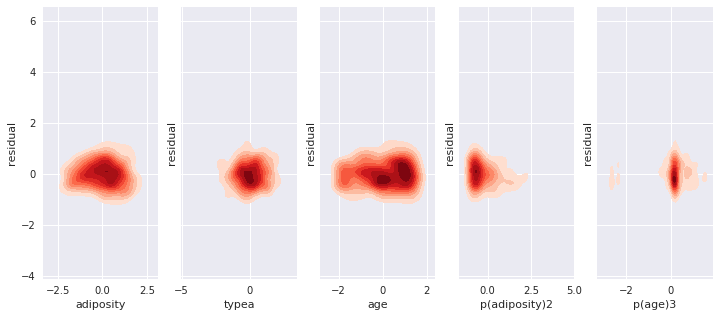

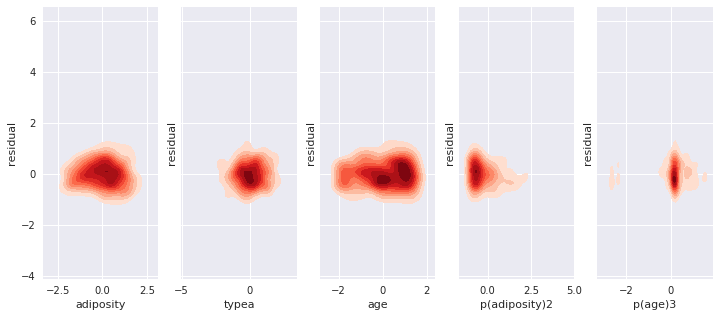

In [27]:
lreg.inspect_cvfold_residuals(X_lr_model, y_lr_model, df_features, figsize=(12,5))

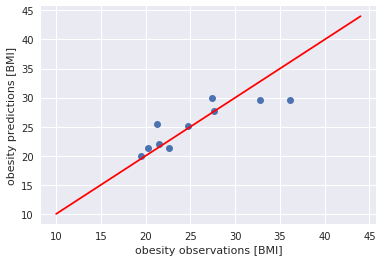

In [28]:
# Fit and test the new model considering the best features

best_features = ['adiposity','age','p(adiposity)2', 'p(age)3', 'typea']
mdl = lm.LinearRegression(fit_intercept=True).fit(X_lr_model[best_features], y_lr_model)
y_lr_predict = mdl.predict(X_lr_test[best_features])

# Rescale obesity back to the original scale
mean_obesity = data['obesity'].mean()
std_obesity = data['obesity'].std()
y_lr_predict_scaled = (y_lr_predict * std_obesity) + mean_obesity 
y_lr_test_scaled = (y_lr_test * std_obesity) + mean_obesity

plt.plot(y_lr_test_scaled, y_lr_predict_scaled, 'o')
plt.xlabel('obesity observations [BMI]')
plt.ylabel('obesity predictions [BMI]')
plt.plot(np.arange(10,45), np.arange(10,45), 'r-')

As expected, the largest linear regression coefficients (in absolute value) are the adiposity and age terms.

In [29]:
w_series = pd.Series()
w_series['w0'] = mdl.intercept_
w_coefs = mdl.coef_
w_names = ['w_{}'.format(col) for col in best_features]
for i, w in enumerate(w_names):
    w_series[w] = w_coefs[i]

w_series

w0                -0.000819
w_adiposity        0.873759
w_age             -0.485076
w_p(adiposity)2    0.170437
w_p(age)3          0.301334
w_typea            0.071089
dtype: float64